<a href="https://colab.research.google.com/github/sahar-mariam/kannada-sentiment-analysis/blob/main/distilBERT_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import torch
from torch.utils.data import DataLoader, Dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
import time
import warnings
warnings.filterwarnings("ignore")


In [3]:
# Load dataset
file_path = '/content/balanced_dataset.csv'  # Update for Colab
data = pd.read_csv(file_path)

# Select relevant columns
data = data[['text', 'sentiment_numeric']]
data = data.dropna()

# Split the data
train_texts, test_texts, train_labels, test_labels = train_test_split(
    data['text'].tolist(),
    data['sentiment_numeric'].tolist(),
    test_size=0.2,
    random_state=42
)

In [4]:
# Tokenization
tokenizer = AutoTokenizer.from_pretrained('distilbert-base-multilingual-cased')

class SentimentDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        tokens = self.tokenizer(
            text,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )
        item = {key: val.squeeze(0) for key, val in tokens.items()}
        item['labels'] = torch.tensor(label, dtype=torch.long)
        return item

train_dataset = SentimentDataset(train_texts, train_labels, tokenizer)
test_dataset = SentimentDataset(test_texts, test_labels, tokenizer)

In [5]:
# Load model
model = AutoModelForSequenceClassification.from_pretrained(
    'distilbert-base-multilingual-cased',
    num_labels=len(set(data['sentiment_numeric']))
)

# Define training arguments
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    save_total_limit=2
)

# Define Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    tokenizer=tokenizer
)

# Train model
trainer.train()


model.safetensors:   0%|          | 0.00/542M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-5-60cee6b03694>:25: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wa

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Epoch,Training Loss,Validation Loss
1,1.041900,1.018300
2,0.822900,0.902465
3,0.727900,0.839233


TrainOutput(global_step=585, training_loss=0.9367046894171299, metrics={'train_runtime': 251.4462, 'train_samples_per_second': 37.081, 'train_steps_per_second': 2.327, 'total_flos': 308787012946944.0, 'train_loss': 0.9367046894171299, 'epoch': 3.0})

In [6]:
# Evaluate model
eval_results = trainer.evaluate()
print("Evaluation Results:", eval_results)

Evaluation Results: {'eval_loss': 0.8392329216003418, 'eval_runtime': 3.2764, 'eval_samples_per_second': 237.153, 'eval_steps_per_second': 14.956, 'epoch': 3.0}


In [7]:
# Predictions
predictions = trainer.predict(test_dataset)
preds = np.argmax(predictions.predictions, axis=1)

# Classification Report
print("Classification Report:")
print(classification_report(test_labels, preds, target_names=['Negative', 'Neutral', 'Positive']))


Classification Report:
              precision    recall  f1-score   support

    Negative       0.65      0.71      0.68       273
     Neutral       0.49      0.59      0.53       230
    Positive       0.83      0.62      0.71       274

    accuracy                           0.64       777
   macro avg       0.66      0.64      0.64       777
weighted avg       0.67      0.64      0.65       777



Confusion Matrix:
[[193  69  11]
 [ 70 135  25]
 [ 32  72 170]]



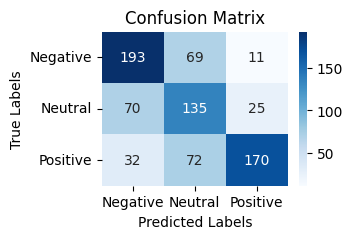

In [8]:
#Confusion Matrix
print("Confusion Matrix:")
conf_matrix = confusion_matrix(test_labels, preds)
print(conf_matrix)
print()

# Plot Confusion Matrix
plt.figure(figsize=(3, 2))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Neutral', 'Positive'], yticklabels=['Negative', 'Neutral', 'Positive'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [9]:
# Predict sentiment for user input with inference time and memory usage
def predict_sentiment(text):
    inputs = tokenizer(
        text,
        return_tensors="pt",
        max_length=128,
        truncation=True,
        padding="max_length"
    )
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    inputs = {key: val.to(device) for key, val in inputs.items()}

    # Measure inference time
    start_time = time.time()
    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits
        prediction = torch.argmax(logits, dim=1).item()
    end_time = time.time()

    inference_time = end_time - start_time

    # Measure memory usage
    if torch.cuda.is_available():
        memory_usage = torch.cuda.memory_allocated(device) / (1024 ** 2)  # Convert bytes to MB
        memory_message = f"{memory_usage:.2f} MB"
    else:
        memory_message = "CUDA not available. Memory usage not applicable."

    sentiment_labels = {
        0: {"English": "Negative", "Kannada": "ನಕಾರಾತ್ಮಕ"},
        1: {"English": "Neutral", "Kannada": "ತಟಸ್ಥ"},
        2: {"English": "Positive", "Kannada": "ಧನಾತ್ಮಕ"}
    }
    return sentiment_labels[prediction], inference_time, memory_message

# Take user input
user_input = input("Enter a Kannada sentence for sentiment prediction: ")
predicted_sentiment, inference_time, memory_message = predict_sentiment(user_input)
print(f"Predicted Sentiment: {predicted_sentiment['English']} ({predicted_sentiment['Kannada']})")
print(f"Inference Time: {inference_time:.4f} seconds")
print(f"Memory Usage: {memory_message}")

Enter a Kannada sentence for sentiment prediction: ನಾನು ಚೆನ್ನಾಗಿದ್ದೇನೆ, ಧನ್ಯವಾದಗಳು
Predicted Sentiment: Positive (ಧನಾತ್ಮಕ)
Inference Time: 0.0693 seconds
Memory Usage: 1566.23 MB
